In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [3]:
df_app = pd.read_csv('AppRNN.csv', index_col='Date', parse_dates=['Date']) #导入数据

# 按照2020年10月1日为界拆分数据集
Train = df_app[:'2020-09-30'].iloc[:,0:1].values #训练集
Test = df_app['2020-10-01':].iloc[:,0:1].values #测试集

from sklearn.preprocessing import MinMaxScaler #导入归一化缩放器
Scaler = MinMaxScaler(feature_range=(0,1)) #创建缩放器
Train = Scaler.fit_transform(Train) #拟合缩放器并对训练集进行归一化

# 对测试数据进行归一化处理
Test = Scaler.transform(Test)



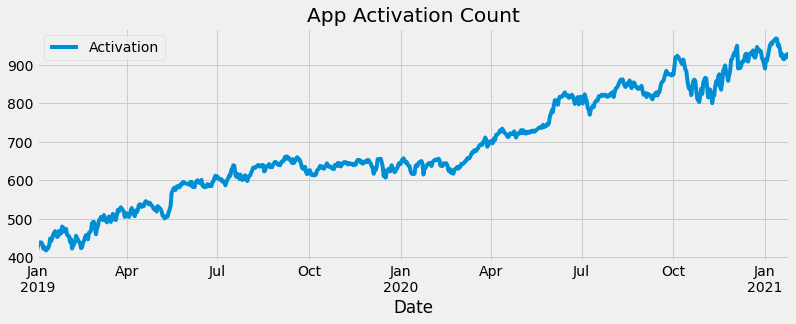

In [4]:
import matplotlib.pyplot as plt #导入matplotlib.pyplot
plt.style.use('fivethirtyeight') #设定绘图风格
df_app["Activation"].plot(figsize=(12,4),legend=True) #绘制激活数
plt.title('App Activation Count') #图题
plt.show() #绘图

In [6]:
# 创建一个函数，将数据集转化为时间序列格式
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# 设定窗口大小
seq_length = 4

x_train, y_train = sliding_windows(Train, seq_length)
# 使用滑动窗口为测试数据创建特征和标签
x_test, y_test = sliding_windows(Test, seq_length)

# 将数据转化为torch张量
testX = Variable(torch.Tensor(np.array(x_test)))
testY = Variable(torch.Tensor(np.array(y_test)))

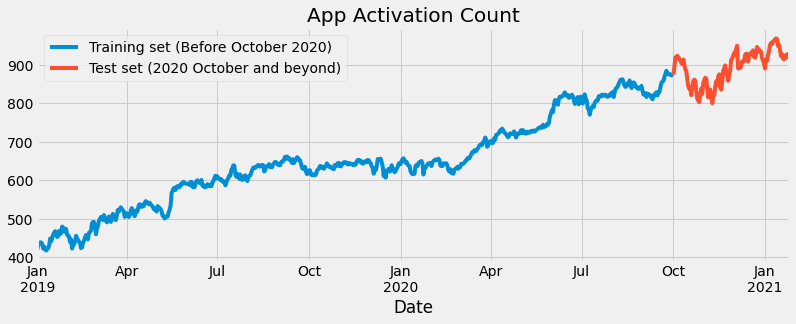

In [7]:
# 以不同颜色为训练集和测试集绘图
df_app["Activation"][:'2020-09-30'].plot(figsize=(12,4),legend=True) #训练集
df_app["Activation"]['2020-10-01':].plot(figsize=(12,4),legend=True) #测试集
plt.legend(['Training set (Before October 2020)','Test set (2020 October and beyond)']) #图例
plt.title('App Activation Count') #图题
plt.show() #绘图

In [8]:
# 设置模型参数
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1

class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        # RNN层
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # 全连接层，用于输出
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隐状态
        h0 = Variable(torch.zeros(num_layers, x.size(0), self.hidden_size))
        
        # 前向传播RNN
        out, _ = self.rnn(x, h0)
        
        # 解码RNN的最后一个隐藏层的输出
        out = self.fc(out[:, -1, :])
        
        return out

In [9]:
# 创建模型
rnn = RNN(input_size, hidden_size, num_layers, output_size)

# 定义损失函数和优化器
criterion = torch.nn.MSELoss()    # 均方误差
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)   # Adam优化器

# 将数据转化为torch张量
trainX = Variable(torch.Tensor(np.array(x_train)))
trainY = Variable(torch.Tensor(np.array(y_train)))

# 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    outputs = rnn(trainX)
    optimizer.zero_grad()
    
    # 计算损失
    loss = criterion(outputs, trainY)
    loss.backward()
    
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.35201
Epoch: 10, loss: 0.04601
Epoch: 20, loss: 0.00509
Epoch: 30, loss: 0.00080
Epoch: 40, loss: 0.00214
Epoch: 50, loss: 0.00084
Epoch: 60, loss: 0.00082
Epoch: 70, loss: 0.00061
Epoch: 80, loss: 0.00057
Epoch: 90, loss: 0.00055


In [10]:
# 使用训练好的模型进行预测
rnn.eval() # 设置模型为评估模式
test_outputs = rnn(testX)

# 将预测结果逆归一化
test_outputs = test_outputs.data.numpy()
test_outputs = Scaler.inverse_transform(test_outputs) # 逆归一化

# 真实测试标签逆归一化
y_test_actual = Scaler.inverse_transform(y_test)

# 输出预测和真实结果
for i in range(len(y_test)):
    print(f"Date: {df_app['2020-10-01':].index[i+seq_length]}, Actual Activation: {y_test_actual[i][0]}, Predicted Activation: {test_outputs[i][0]}")

Date: 2020-10-05 00:00:00, Actual Activation: 923.0, Predicted Activation: 884.0242309570312
Date: 2020-10-06 00:00:00, Actual Activation: 919.0000000000001, Predicted Activation: 892.1919555664062
Date: 2020-10-07 00:00:00, Actual Activation: 915.0, Predicted Activation: 896.2152099609375
Date: 2020-10-08 00:00:00, Actual Activation: 910.0000000000001, Predicted Activation: 894.8662719726562
Date: 2020-10-09 00:00:00, Actual Activation: 905.0000000000001, Predicted Activation: 893.1639404296875
Date: 2020-10-10 00:00:00, Actual Activation: 901.0, Predicted Activation: 889.68994140625
Date: 2020-10-11 00:00:00, Actual Activation: 913.0000000000001, Predicted Activation: 886.35791015625
Date: 2020-10-12 00:00:00, Actual Activation: 900.0, Predicted Activation: 887.63427734375
Date: 2020-10-13 00:00:00, Actual Activation: 888.0000000000001, Predicted Activation: 884.4244995117188
Date: 2020-10-14 00:00:00, Actual Activation: 883.0, Predicted Activation: 879.5723266601562
Date: 2020-10-15

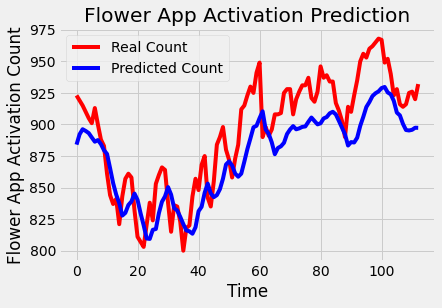

In [13]:
# 定义绘图函数
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Count') #真值
    plt.plot(predicted, color='blue',label='Predicted Count') #预测值
    plt.title('Flower App Activation Prediction') #图题
    plt.xlabel('Time') #X轴时间
    plt.ylabel('Flower App Activation Count') #Y轴激活数
    plt.legend() #图例
    plt.show() #绘图

plot_predictions(y_test_actual,test_outputs) #绘图

In [15]:
import math #导入数学函数
from sklearn.metrics import mean_squared_error
def return_rmse(test,predicted): #定义均方损失函数
    rmse = math.sqrt(mean_squared_error(test, predicted)) #均方损失
    print("MSE损失值 {}.".format(rmse))
return_rmse(y_test_actual, test_outputs)


MSE损失值 27.003487024082244.


In [16]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_actual, test_outputs)
print(f"R2 Score: {r2}")

R2 Score: 0.6158455251443455
